In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import datetime
import pytz
import matplotlib.pyplot as plt
import preprocessing as prep
from bb_binary import FrameContainer, Repository, load_frame_container
import seaborn as sns

# Funktionen

In [2]:
def df_to_timeseries(df):
    gr = df.groupby(by='frame_idx')
    num_columns = df.frame_idx.unique().max() + 1
    u_id = df.id.unique()
    dft = DataFrame(0, index=u_id, columns=np.arange(num_columns))

    for i, group in gr:
        l = group['id']
        dft.loc[l,i] = 1
    
    return dft

In [3]:
def bee_pairs_to_timeseries(close):
    max = close.frame_idx.unique().max() + 1
    close['pair'] = list(zip(close.id_x, close.id_y))
    u_pairs = close.pair.unique()
    dft = DataFrame(0, index=u_pairs, columns=np.arange(max))
    gr = close.groupby('frame_idx')

    for i, group in gr:
        l = group['pair']
        dft.loc[l,i] = 1

    return dft

In [4]:
def fill_gaps(ll):
    for n,k in enumerate(ll[:-2]):
        left = k
        right = ll[n+2]
        m = ll[n+1]

        if (left + right == 2):
            ll[n+1] = 1
    return ll

In [5]:
def timeseries_to_df(dft, df):

    # Zurueckumwandeln in urspruegliches Format: Dabei muessen aber die neu 
    # entstandenen Bienen zu bestimmten Zeitpunkten eingebaut werden.
    #
    # t1  bee1 xpos ypos ...
    #	  bee2 xpos ypos ...
    #     ...  ...  ...
    #		
    # t2  bee2 xpos ypos ...
    #     bee3 xpos ypos ...
    #     ...

    final = DataFrame()

    for col in list(range(dft.shape[1])):

        # die indexes wo ne eins steht merken
        l = dft[dft[col] == 1].index.tolist()

        for item in l:
            # print("{}-{}".format(col,item))
            # element zum timeframe rausholen
            tfe = df[df.frame_idx == col]
            if (tfe[tfe['id'] == item].shape[0] > 0):            
                final = pd.concat([final, tfe[tfe['id'] == item]])
            else:
                pre = df[df.frame_idx == col-1]
                predict = pre[pre['id'] == item]

                post = df[df.frame_idx == col+1]
                postdict = post[post['id'] == item]

                x = (list(predict['xpos'])[0] + list(postdict['xpos'])[0])/2
                y = (list(predict['ypos'])[0] + list(postdict['ypos'])[0])/2
                row = pd.DataFrame({
                    'idx': -100,
                    'xpos':x,
                    'ypos':y,
                    'radius': -100,
                    'zRotation': -100,
                    'frame_idx': col,
                    'timestamp': -100,
                    'cam_id': list(predict['cam_id'])[0],
                    'id':item,
                    'fc_id': -100,
                    'confidence': -100},
                    index = [col])
                final = final.append(row)
    return final

# Dataset

In [170]:
startT = "2016-07-21T15:00:00Z"
startT_dt = datetime.datetime.strptime(startT, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
startT_ts = startT_dt.timestamp()
endT_dt = startT_dt + datetime.timedelta(minutes=5)
endT_ts = endT_dt.timestamp()

In [171]:
df3test = prep.getDF("/mnt/data2016/",startT_ts, endT_ts, 3)

In [172]:
len(df3test.frame_idx.unique())

903

In [173]:
df3test.shape

(116456, 10)

# Ohne Korrektur

In [174]:
df3id = prep.calcIds(df3test, 0.95, 2016)

In [175]:
df3id.shape

(68352, 11)

In [176]:
df_close = prep.get_close_bees_ckd(df3id, 160)

In [177]:
len(df_close)

16683

In [178]:
dfpt = bee_pairs_to_timeseries(df_close)

In [179]:
dfpt.shape

(3274, 903)

# Mit Korrektur

In [180]:
df3idT = df_to_timeseries(df3id)

In [181]:
df3idT.apply(sum, axis=1).sum()

68342

In [182]:
df3idTG = df3idT.apply(fill_gaps, axis=1)

In [183]:
df3idTG.apply(sum, axis=1).sum()

75611

In [184]:
f = timeseries_to_df(df3idTG, df3id)

In [185]:
f.shape

(75621, 11)

In [186]:
df_close2 = prep.get_close_bees_ckd(f, 160)

In [187]:
df_close2.shape

(20744, 3)

In [188]:
dfpt2 = bee_pairs_to_timeseries(df_close2)

In [189]:
dfpt2.shape

(3535, 903)

# Vergleichen der entstandenen Paare

In [190]:
a = df_close.pair.values

In [191]:
a = [(i,j) if i<j else (j,i) for i,j in a]

In [192]:
b = df_close2.pair.values

In [193]:
b = [(i,j) if i<j else (j,i) for i,j in b]

In [194]:
aa = set(a)

In [195]:
bb = set(b)

In [196]:
len(aa.intersection(bb))

3274

In [197]:
len(bb)

3535

In [198]:
len(aa)

3274

In [199]:
dfpt.shape # Ohne Korrektur

(3274, 903)

In [200]:
dfpt2.shape # Mit Korrektur


(3535, 903)

# Was ist neu dazu gekommen?

In [201]:
%matplotlib inline

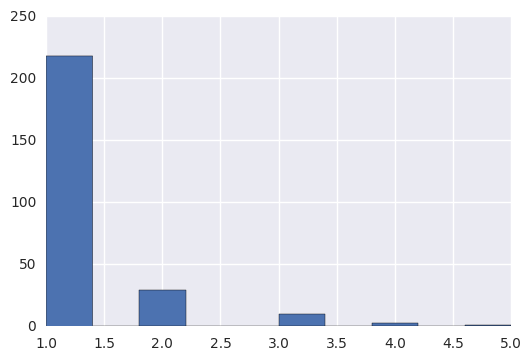

In [217]:
diff = list(bb.difference(aa))
diffDF = dfpt2.loc[diff]
diffDF.apply(sum, axis=1).hist(bins=10)

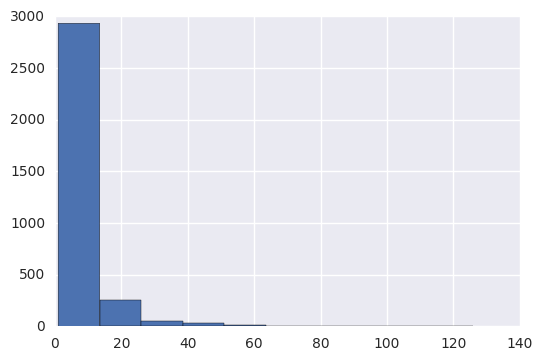

In [218]:
all = list(bb.intersection(aa))
allDF = dfpt2.loc[all]
allDF.apply(sum, axis=1).hist()

# Korrektur afterwards

In [204]:
dfpt.apply(sum, axis=1).sum()

16683

In [205]:
dfpt.head()

,0,1,2,3,4,5,6,7,8,9,...,893,894,895,896,897,898,899,900,901,902
"(1038, 1572)",1,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
"(606, 2566)",1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(846, 2006)",1,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
"(934, 1142)",1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1260, 3304)",1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [206]:
dfptGAP = dfpt.apply(fill_gaps, axis=1)

In [207]:
dfptGAP.apply(sum, axis=1).sum()

18581

# Korrektur After und Korrektur Before VERGLEICHEN

In [208]:
# Korrigierte Paar-Reihen
dfptGAP.shape

(3274, 903)

In [209]:
dfptGAP.apply(sum, axis=1).sum()

18581

In [210]:
# Korrigierte Bienen-Reihen
dfpt2.shape

(3535, 903)

In [211]:
dfpt2.apply(sum, axis=1).sum()

20744

In [212]:
# Ohne Korrektur

In [219]:
dfpt = bee_pairs_to_timeseries(df_close)

In [220]:
dfpt.shape

(3274, 903)

## Gleiche Paare vergleichen

In [221]:
without = list(dfpt.index)

In [222]:
len(without)

3274

In [223]:
after = list(dfptGAP.index)

In [224]:
len(after)

3274

In [225]:
before = list(dfpt2.index)

In [226]:
len(before)

3535

In [227]:
A = set(after)

In [228]:
B = set(before)

In [229]:
C = set(without)

In [230]:
commonPairs = A.intersection(B)

In [231]:
len(commonPairs)

3274

In [232]:
def hamming2(s1, s2):
    """Calculate the Hamming distance between two bit strings"""
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

In [233]:
stath = []

for p in commonPairs:
    bef = dfpt2.loc[[p]].iloc[0].apply(str).str.cat(sep='')
    aft = dfptGAP.loc[[p]].iloc[0].apply(str).str.cat(sep='')
    w = dfpt.loc[[p]].iloc[0].apply(str).str.cat(sep='')
    
    bef1 = bef.count('1')
    aft1 = aft.count('1')
    
    h = hamming2(bef,aft)
    h2 = hamming2(bef,w)
    h3 = hamming2(aft,w)
    
    stath.append((h,h2,h3, bef1, aft1))

In [234]:
hemmingStat = DataFrame(stath, columns=['ba', 'bw', 'aw', 'before1', 'after1'])

In [237]:
hemmingStat.head()

,ba,bw,aw,before1,after1,baP
0,0,0,0,1,1,0.000000
1,0,0,0,1,1,0.000000
2,0,0,0,1,1,0.000000
3,1,2,1,14,13,0.071429
4,0,0,0,1,1,0.000000


In [236]:
hemmingStat['baP'] = hemmingStat.ba/hemmingStat.before1

In [238]:
hemmingStat.ba.mean()

0.67562614538790466

In [239]:
hemmingStat.bw.mean()

1.1417226634086743

In [240]:
hemmingStat.aw.mean()

0.57971899816737937

In [243]:
hemmingStat[hemmingStat.ba != 0].baP.mean()

0.25993360551367822

In [242]:
hemmingStat.baP.mean()

0.1003531085428495

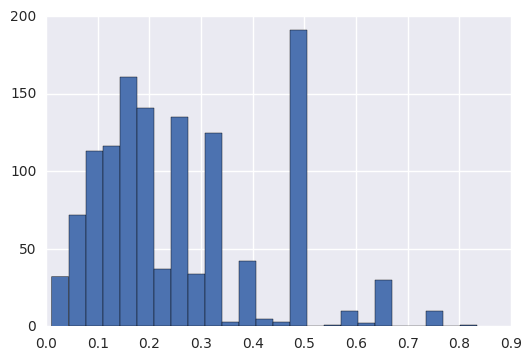

In [250]:
hemmingStat[hemmingStat.ba != 0].baP.hist(bins=25)

In [492]:
reihe = list('0011001100101')

In [493]:
reihe

['0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '1']

In [495]:
fill_gaps(reihe, 1)

['0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '1', '1']

In [452]:
sequence = '10010101101110'

In [453]:
nuller = [i for i in sequence.split('1') if len(i) > 0]

In [454]:
nuller

['00', '0', '0', '0', '0']

In [455]:
einer = [i for i in sequence.split('0') if len(i) > 0]

In [456]:
einer

['1', '1', '1', '11', '111']

In [450]:
if len(nuller) > len(einer):
    result = [item for sublist in zip(nuller,einer) for item in sublist]+[nuller[-1]]
    
if len(nuller) < len(einer):
    result = [item for sublist in zip(einer,nuller) for item in sublist]+[einer[-1]]

if len(nuller) == len(einer):
    if(sequence)
    result = [item for sublist in zip(nuller,einer) for item in sublist]

In [451]:
result

['00', '1', '0', '1', '0', '1', '0', '11', '0', '111']

# Vergleichen Korrektur auf Bienentracks (gapsize=1) mit Korrektur auf PaarReihen Gap1, Gap2, Gap3

In [510]:
def fill_gaps(ll, gap):
    length = -1
    for n,k in enumerate(ll):
        if k == 0:
            if length != -1:
                length += 1
        if k == 1:
            if length <= gap:
                # auffüllen
                for i in list(range(length+1)):
                    ll[n-i] = 1
            length = 0
    return ll

In [463]:
# before gaps1
dfpt2.head(2)

,0,1,2,3,4,5,6,7,8,9,...,893,894,895,896,897,898,899,900,901,902
"(1038, 1572)",1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
"(606, 2566)",1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [521]:
#ohne korrktur
dfpt = bee_pairs_to_timeseries(df_close)

In [515]:
dfpt0 = dfpt.copy()

In [516]:
dfpt.head()

,0,1,2,3,4,5,6,7,8,9,...,893,894,895,896,897,898,899,900,901,902
"(1038, 1572)",1,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
"(606, 2566)",1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(846, 2006)",1,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
"(934, 1142)",1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1260, 3304)",1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [511]:
dfptGAP1 = dfpt.apply(fill_gaps, axis=1, args=[1])

In [512]:
dfptGAP1.head()

,0,1,2,3,4,5,6,7,8,9,...,893,894,895,896,897,898,899,900,901,902
"(1038, 1572)",1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
"(606, 2566)",1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(846, 2006)",1,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
"(934, 1142)",1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1260, 3304)",1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [517]:
dfptGAP2 = dfpt.apply(fill_gaps, axis=1, args=[2])

In [519]:
dfptGAP2.head()

,0,1,2,3,4,5,6,7,8,9,...,893,894,895,896,897,898,899,900,901,902
"(1038, 1572)",1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
"(606, 2566)",1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(846, 2006)",1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
"(934, 1142)",1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1260, 3304)",1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [520]:
dfptGAP3 = dfpt.apply(fill_gaps, axis=1, args=[3])

In [525]:
Before = set(list(dfpt2.index))

In [526]:
G1 = set(list(dfptGAP1.index))

In [527]:
G2 = set(list(dfptGAP2.index))

In [528]:
G3 = set(list(dfptGAP3.index))

In [531]:
len(Before)

3535

In [532]:
inbeidem = Before.intersection(G1)

In [535]:
statG = []

for p in inbeidem:
    bef = dfpt2.loc[[p]].iloc[0].apply(str).str.cat(sep='')
    g1 = dfptGAP1.loc[[p]].iloc[0].apply(str).str.cat(sep='')
    g2 = dfptGAP2.loc[[p]].iloc[0].apply(str).str.cat(sep='')
    g3 = dfptGAP3.loc[[p]].iloc[0].apply(str).str.cat(sep='')
    
    bef1 = bef.count('1')
    g11 = g1.count('1')
    g21 = g2.count('1')
    g31 = g3.count('1')
    
    h = hamming2(bef,g1)
    h2 = hamming2(bef,g2)
    h3 = hamming2(bef,g3)
    
    statG.append((h,h2,h3, bef1, g11, g21, g31))

In [539]:
dfG = DataFrame(statG, columns=['g1', 'g2', 'g3', 'bef1', 'g11', 'g21', 'g31'])

In [540]:
dfG.g1.mean()

0.67562614538790466

In [541]:
dfG.g2.mean()

1.0189370800244348

In [542]:
dfG.g3.mean()

1.3930971288943188

In [544]:
dfG

,g1,g2,g3,bef1,g11,g21,g31
0,0,0,0,1,1,1,1
1,0,0,0,1,1,1,1
2,0,0,0,1,1,1,1
3,1,5,5,14,13,17,17
4,0,0,0,1,1,1,1
5,0,2,5,7,7,9,12
6,6,6,9,18,16,16,19
7,7,5,5,15,8,10,10
8,0,0,3,2,2,2,5
9,0,0,0,1,1,1,1
